In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PowerTransformer

In [8]:
df = pd.read_csv('../data/feature-engineered/reg_df_reduced.csv')

In [12]:
df.dtypes

Unnamed: 0                                int64
OECD_CLI_index                          float64
CSI_index                               float64
OECD_CLI_index_diff1                    float64
OECD_CLI_index_diff3                    float64
OECD_CLI_index_pct_change1              float64
gdp_per_capita_diff1                    float64
gdp_per_capita_pct_change1              float64
recession_probability_lag1              float64
1_year_rate                             float64
3_months_rate                           float64
6_months_rate                           float64
CPI                                     float64
INDPRO                                  float64
10_year_rate                            float64
share_price                             float64
unemployment_rate                       float64
PPI                                     float64
gdp_per_capita                          float64
PPI_CPI_diff                            float64
CPI_rollstd6                            

[0]	train-rmse:4.43971
[1]	train-rmse:4.27688
[2]	train-rmse:4.11995
[3]	train-rmse:3.97394
[4]	train-rmse:3.83883
[5]	train-rmse:3.70790
[6]	train-rmse:3.58142
[7]	train-rmse:3.45746
[8]	train-rmse:3.34608
[9]	train-rmse:3.24488
[10]	train-rmse:3.13968
[11]	train-rmse:3.04054
[12]	train-rmse:2.94505
[13]	train-rmse:2.86063
[14]	train-rmse:2.77857
[15]	train-rmse:2.69869
[16]	train-rmse:2.62676
[17]	train-rmse:2.55465
[18]	train-rmse:2.48721
[19]	train-rmse:2.42117
[20]	train-rmse:2.36630
[21]	train-rmse:2.30330
[22]	train-rmse:2.24534
[23]	train-rmse:2.19221
[24]	train-rmse:2.14345
[25]	train-rmse:2.09167
[26]	train-rmse:2.04352
[27]	train-rmse:1.99879
[28]	train-rmse:1.95724
[29]	train-rmse:1.91516
[30]	train-rmse:1.87619
[31]	train-rmse:1.83749
[32]	train-rmse:1.80483
[33]	train-rmse:1.77428
[34]	train-rmse:1.74509
[35]	train-rmse:1.71571
[36]	train-rmse:1.68674
[37]	train-rmse:1.66155
[38]	train-rmse:1.63688
[39]	train-rmse:1.61411
[40]	train-rmse:1.58931
[41]	train-rmse:1.56901
[4

/Users/donaldaadithiyan/Personal learn dev/RecessionRadar/venv/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/donaldaadithiyan/Personal learn dev/RecessionRadar/venv/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/donaldaadithiyan/Personal learn dev/RecessionRadar/venv/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/donaldaadithiyan/Personal learn dev/RecessionRadar/venv/l

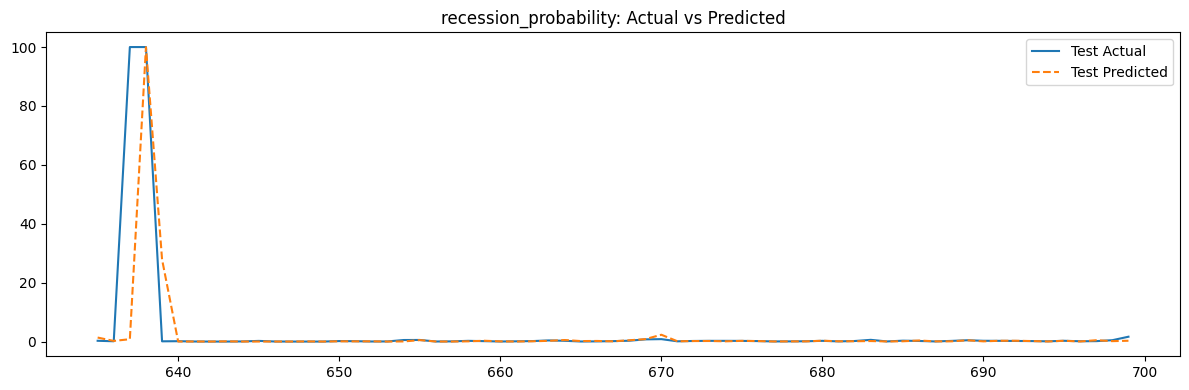

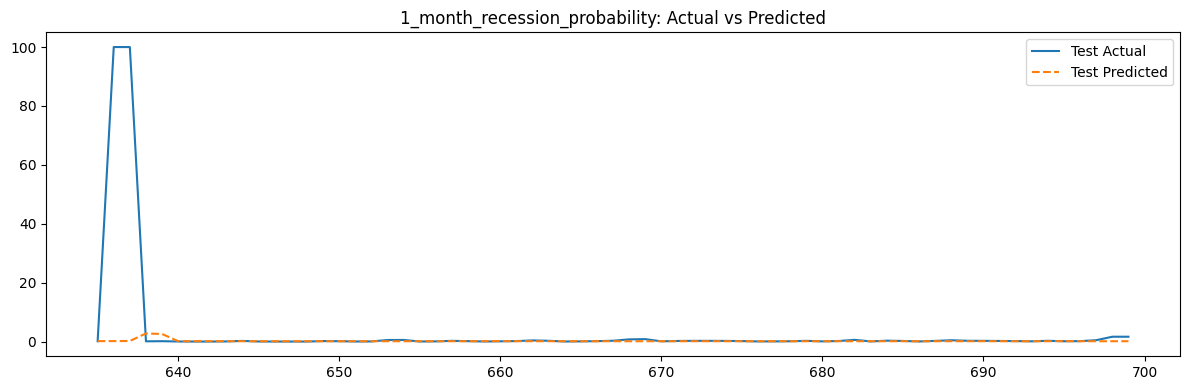

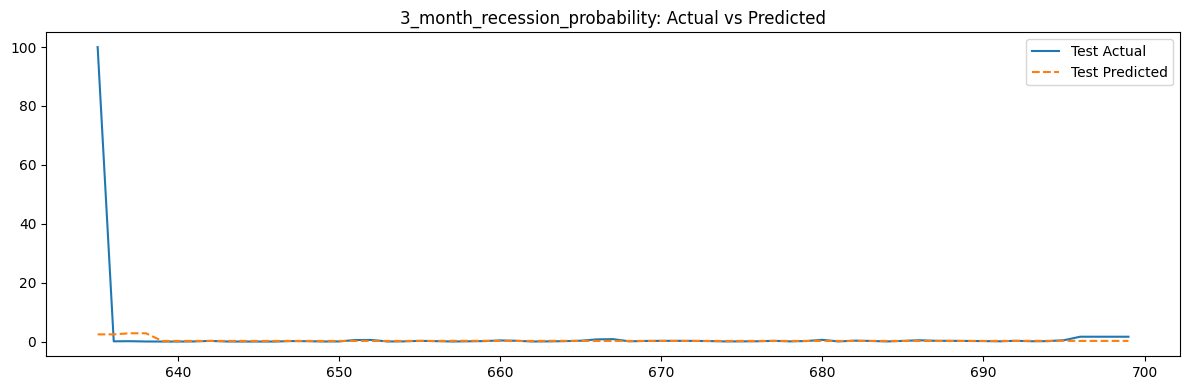

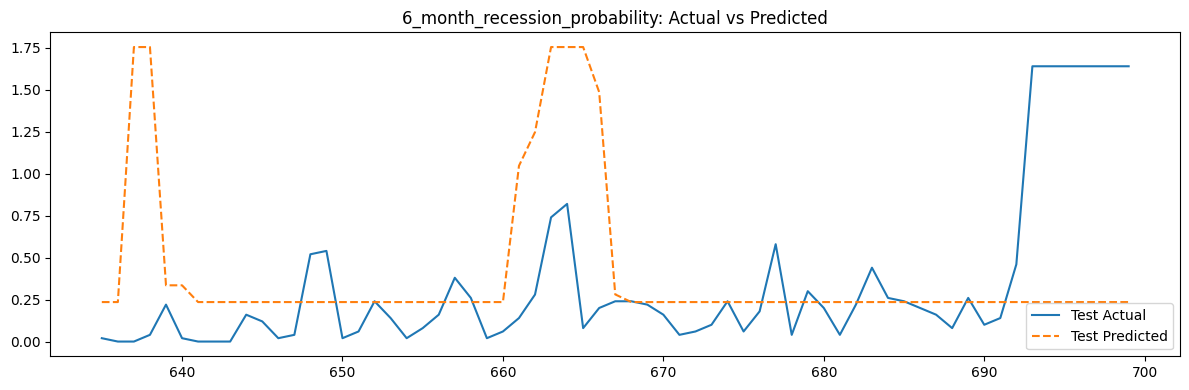

In [15]:
import pandas as pd
import numpy as np
from xgboost import DMatrix, train
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# -------------------------
# Key indicators to keep
# -------------------------
key_indicators = [
    '1_year_rate','3_months_rate','6_months_rate','CPI','INDPRO',
    '10_year_rate','share_price','unemployment_rate','PPI',
    'OECD_CLI_index','CSI_index','gdp_per_capita'
]

# -------------------------
# Targets
# -------------------------
recession_targets = [
    "recession_probability",
    "1_month_recession_probability",
    "3_month_recession_probability",
    "6_month_recession_probability",
]

# -------------------------
# Split train/test
# -------------------------
split_date = "2020-01-01"
df["date"] = pd.to_datetime(df["date"])
train_df = df[df["date"] < split_date].copy()
test_df  = df[df["date"] >= split_date].copy()

X_train = train_df.drop(columns=recession_targets + ["date"])
X_test  = test_df.drop(columns=recession_targets + ["date"])
y_train = train_df[recession_targets]
y_test  = test_df[recession_targets]

# -------------------------
# Clean NaNs
# -------------------------
def clean_data(X_or_y):
    X_or_y = X_or_y.replace([np.inf, -np.inf], np.nan)
    X_or_y = X_or_y.ffill().bfill()
    X_or_y = X_or_y.fillna(0)
    return X_or_y

X_train = clean_data(X_train)
X_test  = clean_data(X_test)
y_train = clean_data(y_train)
y_test  = clean_data(y_test)

# -------------------------
# Feature reduction per target
# -------------------------
top_features_dict = {}
for target in recession_targets:
    rf = RandomForestRegressor(n_estimators=500, random_state=42)
    rf.fit(X_train, y_train[target])
    
    selector = SelectFromModel(rf, prefit=True, max_features=30, threshold=-np.inf)
    selected_features = X_train.columns[selector.get_support()].tolist()
    
    for f in key_indicators:
        if f not in selected_features and f in X_train.columns:
            selected_features.append(f)
    
    top_features_dict[target] = selected_features

# -------------------------
# Logit transform for [0,100] probabilities
# -------------------------
epsilon = 1e-6
def logit_transform(y):
    y_scaled = np.clip(y / 100, epsilon, 1 - epsilon)
    return np.log(y_scaled / (1 - y_scaled))

def inv_logit_transform(y_logit):
    y_prob = 1 / (1 + np.exp(-y_logit))
    return y_prob * 100

# -------------------------
# Weighted / focal-loss-inspired objective
# -------------------------
def focal_loss(y_pred, dtrain, gamma=2.0):
    y_true = dtrain.get_label()
    y_pred_prob = 1 / (1 + np.exp(-y_pred))
    grad = (y_pred_prob - y_true/100) * ((1 - y_pred_prob) ** gamma)
    hess = y_pred_prob * (1 - y_pred_prob) * ((1 - y_pred_prob) ** gamma)
    return grad, hess

# -------------------------
# Train XGBoost per target with focal-loss for short-term horizons
# -------------------------
preds_test = pd.DataFrame(index=test_df.index)
models = {}

for target in recession_targets:
    X_train_target = X_train[top_features_dict[target]]
    X_test_target  = X_test[top_features_dict[target]]
    
    y_train_target = y_train[target].values
    y_test_target  = y_test[target].values

    if np.std(y_train_target) < 1e-3:
        print(f"⚠️ {target} is nearly constant. Predicting mean.")
        preds_test[target] = np.full(len(y_test_target), np.mean(y_train_target))
        models[target] = None
        continue

    y_train_logit = logit_transform(y_train_target)
    dtrain = DMatrix(X_train_target, label=y_train_logit)
    dtest  = DMatrix(X_test_target, label=y_test_target)

    params = {
        "objective": "reg:squarederror",
        "max_depth": 5,
        "eta": 0.05,
        "subsample": 0.9,
        "colsample_bytree": 0.9,
        "seed": 42,
        "verbosity": 1,
    }

    # Use focal-loss for short-term horizons
    use_focal = target in ["1_month_recession_probability", "3_month_recession_probability", "6_month_recession_probability"]
    
    bst = train(
        params,
        dtrain,
        num_boost_round=500,
        obj=(lambda y_pred, dtrain: focal_loss(y_pred, dtrain, gamma=2.0)) if use_focal else None,
        evals=[(dtrain, "train")]
    )

    y_pred_logit = bst.predict(dtest)
    y_pred = inv_logit_transform(y_pred_logit)
    preds_test[target] = np.clip(y_pred, 0, 100)
    models[target] = bst

# -------------------------
# Evaluation
# -------------------------
def evaluate(y_true, y_pred, dataset_name="Dataset"):
    print(f"\n=== Evaluation on {dataset_name} ===")
    for target in recession_targets:
        mae = mean_absolute_error(y_true[target], y_pred[target])
        rmse = mean_squared_error(y_true[target], y_pred[target], squared=False)
        r2 = r2_score(y_true[target], y_pred[target])
        print(f"{target}: MAE={mae:.4f}, RMSE={rmse:.4f}, R2={r2:.4f}")

evaluate(y_test, preds_test, "Test")

# -------------------------
# Plot Actual vs Predicted
# -------------------------
for target in recession_targets:
    plt.figure(figsize=(12, 4))
    plt.plot(test_df.index, y_test[target], label="Test Actual")
    plt.plot(test_df.index, preds_test[target], label="Test Predicted", linestyle="--")
    plt.title(f"{target}: Actual vs Predicted")
    plt.legend()
    plt.tight_layout()
    plt.show()
